In [13]:

!export PYTHONPATH=$PYTHONPATH:"/Users/ratlifflj/repos/teach/S22EE445-Dev/lecture-ntbks/utils/"
!echo $PYTHONPATH

## Module 2 - Lecture 3
### Least squares classifiers

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from numpy.polynomial.polynomial import polyvander
from numpy.polynomial.polynomial import polyval
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import pickle as pk
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LogisticRegression

# for ROC
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# put the cf_matrix.py file in the current directory or change your pythonpath (as above) to 
# have the location where you stored cf_matrix.py
from cf_matrix import make_confusion_matrix as cfmat
sns.set_theme(style="whitegrid")

fs=24
lw=4

rms = lambda x: np.sqrt(np.mean(np.square(x))) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: Least Squares Classifier with Iris Data
The iris data set is a standard data set used in basic ML tasks. This data sets consists of three different types of irises'---i.e., Setosa, Versicolour, and Virginica---whose petal and sepal length are stored in a $150\times 4$ `numpy.ndarray`.

The rows are the samples and the columns are `sepal length`, `sepal width`, `petal length` and `petal width`, respectively.

You can actually load this data set directly from `scikit-learn` or from the file on the course website. 

`from sklearn import datasets`

`iris = datasets.load_iris()`



See [here](https://en.wikipedia.org/wiki/Iris_flower_data_set) and [here](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) for more information on this dataset.



#### Confusion Matrix
Before diving into the example, we need some functions to compute the error rates and confusion matrix we learned about in lecture.

In [37]:
numTP = lambda y,yhat: sum([1 for i in range(len(y)) if y[i] == True and yhat[i] == True])
numFN = lambda y,yhat: sum([1 for i in range(len(y)) if y[i] == True and yhat[i] == False])
numFP = lambda y,yhat: sum([1 for i in range(len(y)) if y[i] == False and yhat[i] == True])
numTN = lambda y,yhat: sum([1 for i in range(len(y)) if y[i] == False and yhat[i] == False]) 
confusion_matrix = lambda y,yhat: np.vstack([[numTP(y,yhat),numFN(y,yhat)],[numFP(y,yhat),numTN(y,yhat)]])
error_rate = lambda y,yhat: (numFN(y,yhat) + numFP(y,yhat)) / len(y)
error_rate2 = lambda y,yhat: np.average(y != yhat)

### Example 1a: Classification Example
We are going to try and learn a classifier for virginica based on the four features. Our classifier is fit using
$$A=\begin{bmatrix} \boldsymbol{1} & D\end{bmatrix}\in \mathbb{R}^{5\times 150}$$
where $D$ is the iris data containing the four features. 

The $y\in \mathbb{R}^{150}$ vector contains $100$ entries with the value `False` and $50$ entries with the value `True`. To create this, we create a boolean vector using `y=np.hstack([np.full(50, False),np.full(50, False),np.full(50, True)])` and then we define $b=2\cdot v-1$. We then solve
$$\min_x \|Ax-b\|^2_2$$
and use
$$\hat{y}=\mathrm{sign}(A\hat{x})$$
as our classifier.

shape of iris array :  (150, 4)


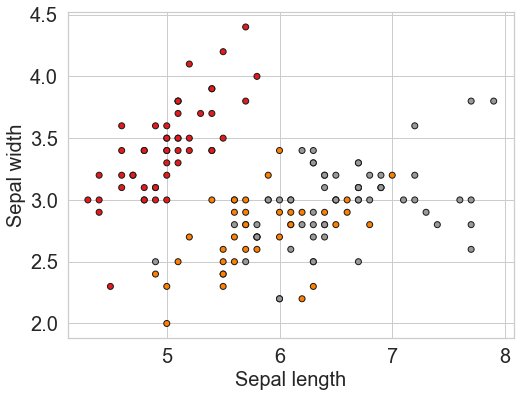

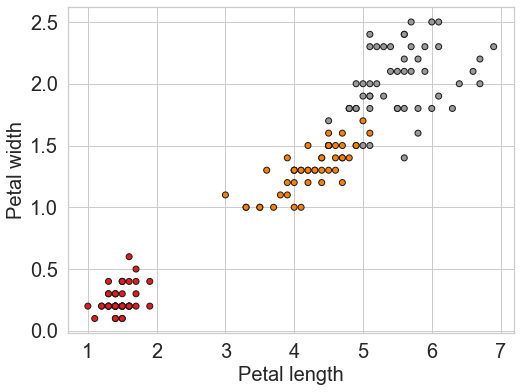

In [38]:
#irisD=pk.load(open('./data/iris_data.p','rb'))
#iris=np.vstack([irisD["setosa"],irisD["versicolor"],irisD["virginica"]])
# or from scikit-learn
irisD = datasets.load_iris()

iris = irisD['data'] 
print("shape of iris array : ", np.shape(iris))
y = irisD.target
# Plot the training points
plt.figure(figsize=(8, 6))
plt.clf()
plt.scatter(iris[:, 0], iris[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length", fontsize=fs-4)
plt.ylabel("Sepal width", fontsize=fs-4)
plt.tick_params(labelsize=fs-4)
plt.savefig('./figs/sepal_features.png')
plt.figure(figsize=(8, 6))
plt.scatter(iris[:, 2], iris[:, 3], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Petal length", fontsize=fs-4)
plt.ylabel("Petal width", fontsize=fs-4)
plt.tick_params(labelsize=fs-4)
plt.savefig('./figs/petal_features.png')

error rate : 7.33%


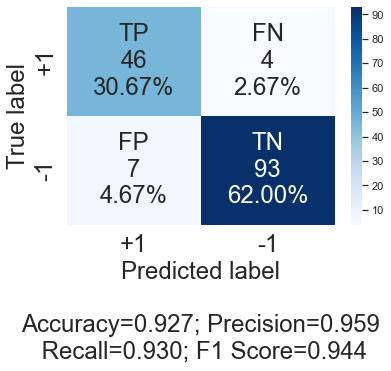

In [39]:
# create the y vector
# we put false for the first two types of iris and true for the third type (namely virginica)
# i.e. if k == virginica: y[k] = True (1) ; else False (0)
y = np.hstack([np.full(50, False),np.full(50, False),np.full(50, True)])
b=2*y-1

# Create the A matrix by stacking ones with the iris array
A = np.hstack([np.ones((150,1)), iris])

## Solve least squares
theta = la.lstsq(A,b,rcond=None)[0]

## get classification
yhat = A@theta > 0 #regression classifier 

## Create Confusion Matrix and plot it
C = confusion_matrix(y,yhat)
cfmat(C, group_names=['TP', 'FN', 'FP', 'TN'],categories=['+1','-1'])
print("error rate : {:.2f}%".format(error_rate(y,yhat)*100))

plt.savefig('./figs/cfmatrix_iris.png', bbox_inches='tight')

In [5]:
print("Coefficients : \n ", theta)

Coefficients : 
  [-2.39056373 -0.09175217  0.40553677  0.00797582  1.10355865]


### Example 1b:  Cross Validation

In [14]:
np.random.seed(10)
n=150
X = A
nfold = int(n/5); # size of first four folds
print("size of first four folds : ", nfold)

I = np.random.permutation(n) # random permutation of numbers 1...nfolds
coeff  = np.zeros((5,5)) 
errors = np.zeros((5,2))

rms_train = {}
error_rates ={}
rms_test = {}
coeff={}
for k in range(0,5):
    if k == 0:
        Itrain = I[nfold::];
        Itest = I[0:nfold];
        #print(np.shape(Itest))
        #break
    elif k == 4:
        Itrain = I[0:4*nfold];
        Itest = I[4*nfold::];
    else:
        Itrain = np.concatenate((I[0:k*nfold],I[(k+1)*nfold::]))
        Itest = I[k*nfold:(k+1)*nfold]

    n_train = len(Itrain)
    n_test = len(Itest)

    y_ = y[Itrain]
    b=2*y_-1


    A_=X[Itrain.tolist(),:]

    theta = la.lstsq(A_,b, rcond=None)[0] 

    coeff[k] = theta;
    y_train=A_@ theta>0
    #rms_train[k] = rms(A_@ theta - b);#
    A_=X[Itest,:]
    yhat=A_ @ theta>0 
    b_=2*y[Itest]-1
    b_hat=2*yhat-1
    rms_test[k] = rms(b_hat- b_)
    error_rates[k]=error_rate(yhat,y[Itest])*100
    


size of first four folds :  30


Below we print out the error rates for the test data for each of the folds. Roughly speaking (for this selected seed) the rates are 3-10%. Change the seed and see how that impacts the results. but our test sets are not large enough to predict future performance more accurately than this. (This is an example of the limitation of cross-validation when the data set is small; see the discussion on page 268.)

In [27]:
np.set_printoptions(precision=3)
for key in error_rates:
    print("fold {}, error rate : {:.2f}%".format(key,error_rates[key]))

fold 0, error rate : 6.67%
fold 1, error rate : 10.00%
fold 2, error rate : 6.67%
fold 3, error rate : 6.67%
fold 4, error rate : 3.33%


In [12]:
A_@theta>0

array([False, False,  True, False,  True, False, False,  True,  True,
        True, False, False,  True,  True, False, False,  True, False,
        True, False, False, False, False,  True,  True,  True, False,
       False,  True, False])

## Example 2: Multi-Class Classification
We will generate a random set of $y$ and $\hat{y}$ values for a class size of $K=4$ and explore the confusion matrix concept.

In [53]:
K = 4
np.random.seed(10)
y = np.random.randint(K,size=100)
yhat = np.random.randint(K,size=100)

error_rate = lambda y,yhat: np.mean(y != yhat)

def cf_matrix_K(y, yhat, K):
    C = np.zeros((K,K))
    for i in range(K):
        for j in range(K):
            C[i,j] = sum(np.logical_and(y == i, yhat == j))
    return C


To understand what the line defining the $C_{ij}$ entry of the confusion matrix is doing, try running the code below for true label $y=i$ and predicted label $\hat{y}=j$.

In [54]:
sum(np.logical_and(y == 0, yhat == 1))

11

Now, let's compute the confusion matrix and print out some error stats.

In [55]:
C = cf_matrix_K(y,yhat,K)
print("Confusion Matrix : \n", C)
print("total error rate : {:.1f}%".format(error_rate(y,yhat)*100))

tot_err_rate=lambda C: 1-np.sum(np.diag(C))/np.sum(C)
true_err_rate=lambda C,i: C[i,i]/np.sum(C[i,:])

print("total error rate : {:.1f}%".format( tot_err_rate(C)*100))
print()
for i in range(K):
    print("true label rate, group {} : {:.1f}%".format(i, true_err_rate(C,i)*100))

Confusion Matrix : 
 [[ 6. 11.  7.  8.]
 [ 6.  6.  8.  5.]
 [ 8.  7.  8.  0.]
 [ 3.  7.  4.  6.]]
total error rate : 74.0%
total error rate : 74.0%

true label rate, group 0 : 18.8%
true label rate, group 1 : 24.0%
true label rate, group 2 : 34.8%
true label rate, group 3 : 30.0%


We can also visualize our results.

<AxesSubplot:>

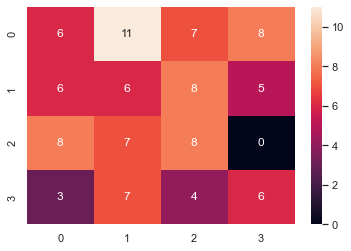

In [58]:
df_cm = pd.DataFrame(cf_matrix_K(y,yhat,K) )
sns.heatmap(df_cm, annot=True)

### Least Squares Multi-Class Classification
Now let's actually implement a least squares multi-class classifier.

In [103]:
np.random.seed(10)
#matrix least squares
def one_hot(ycl,K):
    N = len(ycl)
    Y = np.zeros((N,K))
    for j in range(K):
        Y[np.where(ycl==j),j] = 1
    return Y

def ls_multiclass(X,ycl,K):
    n,N = np.size(X),np.size(X)
    theta = la.lstsq(X.T, (2*one_hot(ycl,K)-1),rcond=None)[0]
    yhat = np.argmax(np.matmul(X.T,theta),1)
    return theta,yhat

In [112]:
np.random.seed(10)
irisD_=pk.load(open('../data/iris_data.p','rb'))
# load iris data
setosa = irisD['data'][np.where(irisD.target==0),:].reshape(50,4) #irisD_["setosa"] # # irisD["setosa"]
versicolor = irisD['data'][np.where(irisD.target==1),:].reshape(50,4) #irisD_["versicolor"] # #irisD["versicolor"]
virginica = irisD['data'][np.where(irisD.target==2),:].reshape(50,4) #irisD_["virginica"] # #irisD["virginica"]
I1 = np.random.permutation(50)
I2 = np.random.permutation(50)
I3 = np.random.permutation(50)

#4x120 data matrix: 4 features per flower, 120 flowers
#transposed shape shows 4 arrays, 1 per feature, with 120 data pts in each
Xtrain = np.vstack([setosa[I1[:40],:],versicolor[I2[:40],:],virginica[I3[:40],:]]).T 
#add constant feature array 1, now shape 5x120
Xtrain = np.vstack([np.ones((1,120)),Xtrain]) 
Ytrain = np.vstack([np.full(40,0),np.full(40,1),np.full(40,2)]).ravel()

Xtest = np.vstack([setosa[I1[40:],:],versicolor[I2[40:],:],virginica[I3[40:],:]]).T 
Xtest = np.vstack([np.ones((1,30)),Xtest]) 
Ytest = np.vstack([np.full(10,0),np.full(10,1),np.full(10,2)]).ravel()

training error rate : 20.0%
testing error rate  : 3.3%


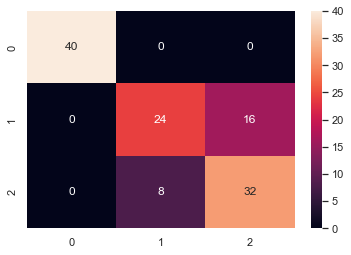

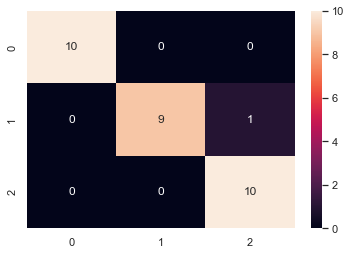

In [114]:
theta,yhat_train = ls_multiclass(Xtrain,Ytrain,3)

Ctrain = cf_matrix_K(Ytrain,yhat_train,3)
plt.figure()
sns.heatmap(pd.DataFrame(Ctrain), annot=True)
error_train = error_rate(Ytrain,yhat_train)

yhat_test = np.argmax(np.matmul(Xtest.T,theta),1)
Ctest = cf_matrix_K(Ytest,yhat_test,3)
plt.figure()
sns.heatmap(pd.DataFrame(Ctest), annot=True)
error_test = error_rate(Ytest,yhat_test)

print("training error rate : {:.1f}%".format(error_train*100))
print("testing error rate  : {:.1f}%".format(error_test*100))


## Example 3: Binary Classifier and ROC
In this example we will explore the concept of a binary classifier with an ROC curve. 


In [22]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

To fit a binary logistic regression with sklearn, we use the LogisticRegression module with multi_class set to "ovr" and fit X and y.

Target variables  :  ['malignant' 'benign']
Unique values of the target variable [0 1]
Counts of the target variable : [212 357]


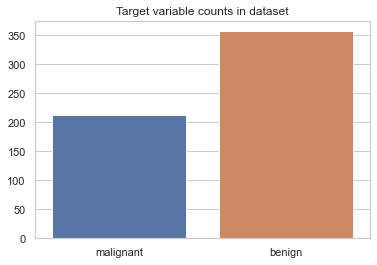

In [24]:
print('Target variables  : ', dataset['target_names'])

(unique, counts) = np.unique(dataset['target'], return_counts=True)

print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)

sns.barplot(x=dataset['target_names'], y=counts)
plt.title('Target variable counts in dataset')
plt.show()

In [25]:
X = dataset['data']
y = dataset['target']
standardizer = StandardScaler()
X = standardizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  88
False Positive(FP) =  3
True Negative(TN)  =  50
False Negative(FN) =  2
Accuracy of the binary classification = 0.965


In [34]:

# calculate the fpr and tpr for all thresholds of the classification
probs=model.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

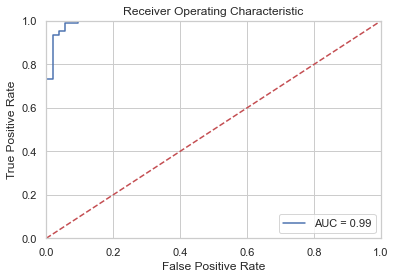

In [35]:

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Let's create a fake data set that is harder to classify 
Play around with the size of the data set (i.e., `n_samples`). You will see that the more samples the harder it is to draw a line to separate the two groups. You can also change the seed.

In [171]:

X, y = sk.datasets.make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, n_samples=1000
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

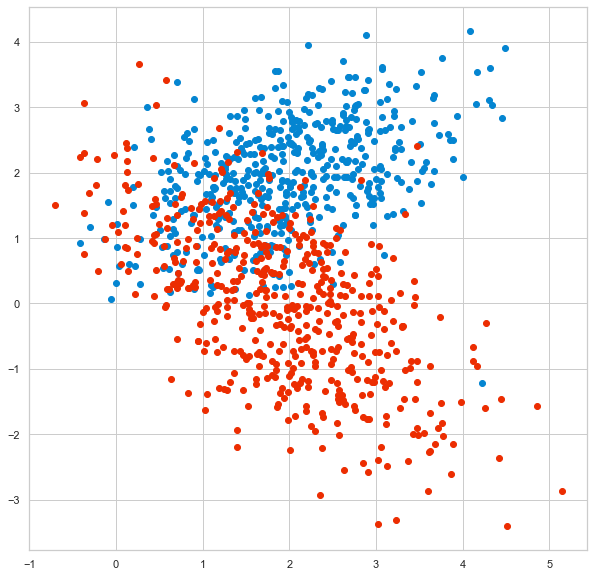

In [172]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
plt.scatter(X[np.where(y==0),0],X[np.where(y==0),1], color='xkcd:cerulean')
plt.scatter(X[np.where(y==1),0],X[np.where(y==1),1], color='xkcd:tomato red')
#ax.set_aspect('equal')


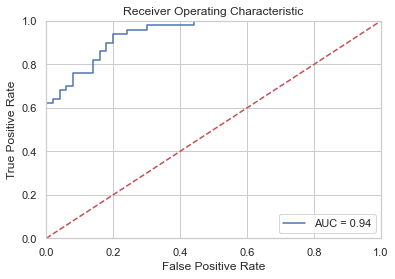

In [173]:

# standardize the data
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.1, random_state=0)

# set up the model and fit it
model = LogisticRegression()
model.fit(X_train, y_train)

# predictions from model [not using but in case you want to see]
predictions = model.predict(X_test)

# compute the probability for each test point that its in the class
probs=model.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Let's also plot the figure from the book, and implement manually

In [174]:
gettpr=lambda y,yhat: numTP(y,yhat)/(numTP(y,yhat)+numFN(y,yhat))
getfpr=lambda y,yhat: numFP(y,yhat)/(numFP(y,yhat)+numTN(y,yhat))

In [175]:
verbose=False
b=2*y_train-1

yhat_train=[]
yhat_test=[]
err_train=[]
err_test=[]
tpr=[]
fpr=[]
Ntrue=np.sum(np.where(y_test==1))
alphas=np.linspace(-2,2,100)
for alpha in alphas:
    ## Solve least squares
    theta = la.lstsq(X_train,b,rcond=None)[0]

    ## get classification
    yhat_train.append(X_train@theta > alpha) #regression classifier 
    yhat_test.append(X_test@theta>alpha)
    
    if verbose:
        print("training error : ", error_rate(y_train,yhat_train[-1])*100)
        print("testing error  : ", error_rate(y_test,yhat_test[-1])*100)
    err_train.append(error_rate(y_train,yhat_train[-1]))
    err_test.append(error_rate(y_test,yhat_test[-1]))
    tpr.append(gettpr(y_test,yhat_test[-1]))
    fpr.append(getfpr(y_test,yhat_test[-1]))
err_train=np.asarray(err_train)
err_test=np.asarray(err_test)
tpr=np.asarray(tpr)
fpr=np.asarray(fpr)

Text(0, 0.5, 'rate')

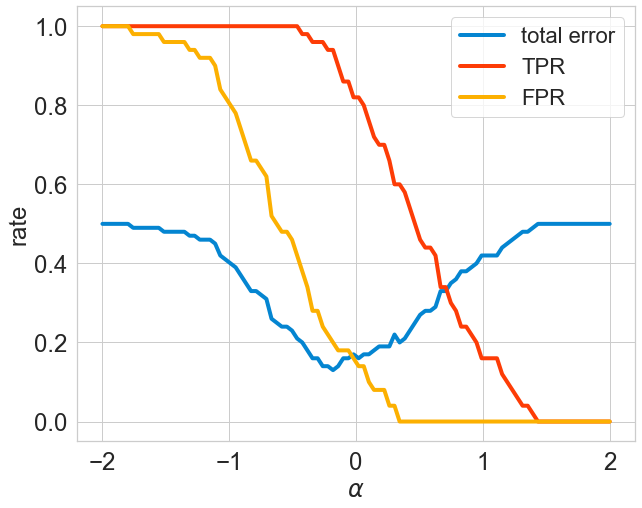

In [176]:
plt.figure(figsize=(10,8))
plt.plot(alphas,err_test, color='xkcd:cerulean', linewidth=lw,label='total error')
plt.plot(alphas,tpr, color='xkcd:red orange', linewidth=lw,label='TPR')
plt.plot(alphas,fpr, color='xkcd:yellow orange', linewidth=lw,label='FPR')
plt.tick_params(labelsize=fs)
plt.legend(fontsize=fs-2)
plt.xlabel(r'$\alpha$',fontsize=fs)
plt.ylabel(r'rate',fontsize=fs)

In [177]:
theta = la.lstsq(X_train,b,rcond=None)[0]
alpha=0
## get classification
ytilde_test=X_test@theta
ytilde_train=X_train@theta
yhat_train=X_train@theta > alpha #regression classifier 
yhat_test=X_test@theta>alpha

Text(0.5, 8.95999999999998, '$\\alpha$')

<Figure size 1440x576 with 0 Axes>

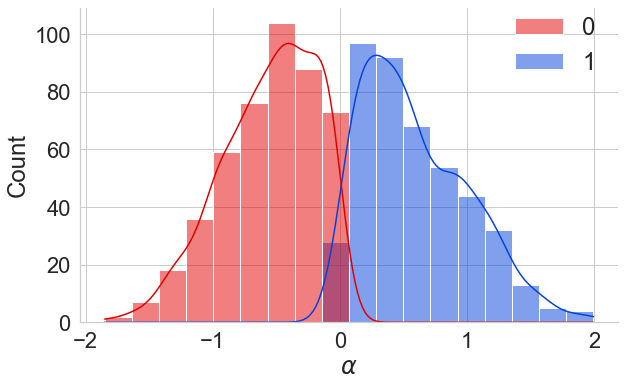

In [178]:
plt.figure(figsize=(20,8))


g=sns.displot([ytilde_train[np.where(yhat_train==False)],ytilde_train[np.where(yhat_train==True)]], kde=True, 
             bins=int(180/10), color = 'xkcd:bright blue',aspect=1.7,palette=['xkcd:red', 'xkcd:blue'])
sns.move_legend(g, "upper right", bbox_to_anchor=(0.9, 1), fontsize=fs)
plt.tick_params(labelsize=fs-2)
plt.ylabel("Count", fontsize=fs)
plt.xlabel(r"$\alpha$", fontsize=fs)

Text(0.5, 0, 'false positive rate')

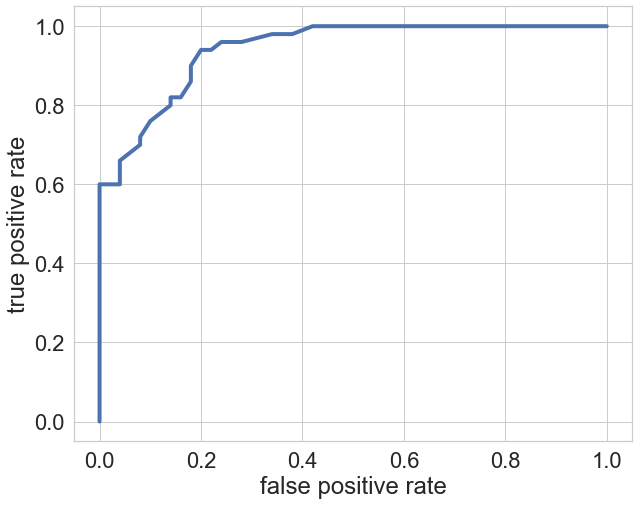

In [179]:
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr, linewidth=lw)
plt.tick_params(labelsize=fs-2)
plt.ylabel("true positive rate", fontsize=fs)
plt.xlabel(r"false positive rate", fontsize=fs)


In [180]:
alphas[50], tpr[50],fpr[50]

(0.020202020202020332, 0.82, 0.14)